<a href="https://colab.research.google.com/github/meet21039/EEE-GS-513--Machine-Learning-Course-Project/blob/main/notebooks/Fracture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
IMG_SIZE = (128, 128)   # standard for transfer learning; reduce to (128,128) to save memory
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Cell 2 - Build dataframe of image paths and patient-level labels
DATA_DIR = "/content/drive/MyDrive/Train"   # change to your dataset folder in Colab
# Expect structure: DATA_DIR/patient_x/*.jpg (or png). Label could be in a labels.csv or inferred from folder name.

# Option A: If you have labels.csv with columns ['patient','label']
labels_csv = os.path.join(DATA_DIR, 'labels.csv')
if os.path.exists(labels_csv):
    labels_df = pd.read_csv(labels_csv)
    # assume 'patient' column matches folder names and label is 0/1
    rows = []
    for _, r in labels_df.iterrows():
        p = r['patient']
        lab = int(r['label'])
        pdir = Path(DATA_DIR) / str(p)
        if pdir.exists():
            for img in pdir.glob('*'):
                if img.suffix.lower() in ['.jpg','.jpeg','.png']:
                    rows.append({'patient': p, 'path': str(img), 'label': lab})
    df = pd.DataFrame(rows)
else:
    # Option B: infer label from patient folder name (e.g., patient_001_pos or contains 'yes','tumor','abnormal')
    rows = []
    for pdir in Path(DATA_DIR).iterdir():
        if pdir.is_dir():
            name = pdir.name.lower()
            if any(x in name for x in ['yes','tumor','abnormal','fracture','pos','positive']):
                lab = 1
            elif any(x in name for x in ['no','normal','neg','negative','healthy']):
                lab = 0
            else:
                # unknown, ask user or skip (we assume 0 by default - change as needed)
                lab = 0
            for img in pdir.glob('*'):
                if img.suffix.lower() in ['.jpg','.jpeg','.png','.png']:
                    rows.append({'patient': pdir.name, 'path': str(img), 'label': lab})
    df = pd.DataFrame(rows)

# quick stats
print("Total images:", len(df))
print("Unique patients:", df['patient'].nunique())
print(df)


Total images: 9756
Unique patients: 2
       patient                                               path  label
0     positive  /content/drive/MyDrive/Train/positive/patient0...      1
1     positive  /content/drive/MyDrive/Train/positive/patient0...      1
2     positive  /content/drive/MyDrive/Train/positive/patient0...      1
3     positive  /content/drive/MyDrive/Train/positive/patient0...      1
4     positive  /content/drive/MyDrive/Train/positive/patient0...      1
...        ...                                                ...    ...
9751  negative  /content/drive/MyDrive/Train/negative/patient0...      0
9752  negative  /content/drive/MyDrive/Train/negative/patient0...      0
9753  negative  /content/drive/MyDrive/Train/negative/patient0...      0
9754  negative  /content/drive/MyDrive/Train/negative/patient0...      0
9755  negative  /content/drive/MyDrive/Train/negative/patient0...      0

[9756 rows x 3 columns]


In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)


print("Train / Test sizes:", len(train_df), len(test_df))
out = Path("/content/drive/MyDrive/ML")
out.mkdir(exist_ok=True)
train_df.to_csv(out/"train.csv", index=False)
test_df.to_csv(out/"test.csv", index=False)
print("Saved CSVs to", out)

Train / Test sizes: 7804 1952
Saved CSVs to /content/drive/MyDrive/ML


In [6]:
# Cell 4 - preprocessing function (uses OpenCV)
IMG_H, IMG_W = IMG_SIZE

def read_and_preprocess(path, clahe=True):
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError("cv2.imread returned None")
        if clahe:
            clahe_op = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img = clahe_op.apply(img)
        img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
        img = img.astype('float32') / 255.0
        img = np.stack([img, img, img], axis=-1)
        return img
    except Exception as e:
        print("❌ Error reading:", path, "Reason:", e)
        # return a blank image so TF pipeline doesn’t break
        return np.zeros((*IMG_SIZE, 3), dtype='float32')



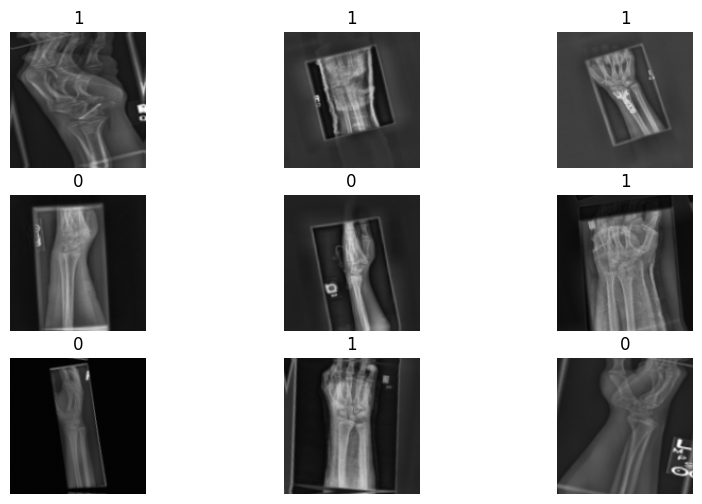

In [7]:
# Cell 5 - tf.data pipeline creation
def df_to_tf_dataset(df, shuffle=True, augment=False):
    paths = df['path'].values
    labels = df['label'].astype('float32').values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)

    # load & preprocess using numpy_function for OpenCV
    def _load(path, label):
        img = tf.numpy_function(lambda p: read_and_preprocess(p.decode('utf-8')), [path], tf.float32)
        # Ensure the shape is set after the numpy function call
        img.set_shape((IMG_H, IMG_W, 3))
        return img, label

    # Filter out images that failed to load (returned None)
    # We can check for NaN values which might result from failed loading
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE).filter(lambda img, label: tf.reduce_all(tf.math.is_finite(img)))


    if augment:
        aug = keras.Sequential([
            layers.RandomFlip("horizontal"),            # horizontal OK for most X-rays; verify for your task
            layers.RandomRotation(0.04),
            layers.RandomZoom(0.06),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_tf_dataset(train_df, shuffle=True, augment=True)
test_ds  = df_to_tf_dataset(test_df, shuffle=False, augment=False)

# quick check — show a few images
for imgs, labs in train_ds.take(1):
    plt.figure(figsize=(10,6))
    for i in range(min(9, imgs.shape[0])):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(imgs[i].numpy())
        plt.title(int(labs[i].numpy()))
        plt.axis('off')
    plt.show()

In [8]:
# Cell 6 - baseline CNN
def make_baseline_cnn(input_shape=(IMG_H, IMG_W, 3)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    model = models.Model(inp, out, name='baseline_cnn')
    return model

model = make_baseline_cnn()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy(name='acc'), metrics.AUC(name='auc')])
model.summary()


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,273 (368.25 KB)

 Trainable params: 93,825 (366.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Cell 7 - callbacks and compute class weights
checkpoint_path = "/content/drive/MyDrive/ML/final_mri_model.keras"
cbs = [
    callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=6, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, verbose=1)
]

# compute class weights (image-level)
counts = train_df['label'].value_counts().to_dict()  # e.g., {0: N0, 1: N1}
total = sum(counts.values())
class_weight = {int(k): total/(len(counts)*v) for k,v in counts.items()}
print("Train counts:", counts, "class_weight:", class_weight)


Train counts: {0: 4615, 1: 3189} class_weight: {0: 0.8455037919826652, 1: 1.2235810598933836}


In [10]:
# Cell 8 - train baseline
EPOCHS = 20
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    callbacks=cbs,
                    class_weight=class_weight)


Epoch 1/20
    110/Unknown 85s 678ms/step - acc: 0.5267 - auc: 0.5663 - loss: 0.7670❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study2_negative._image2.png Reason: cv2.imread returned None
    162/Unknown 107s 596ms/step - acc: 0.5441 - auc: 0.5846 - loss: 0.7464❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study2_negative._image3.png Reason: cv2.imread returned None
    201/Unknown 122s 559ms/step - acc: 0.5524 - auc: 0.5923 - loss: 0.7374❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study1_negative._image1.png Reason: cv2.imread returned None
244/244 ━━━━━━━━━━━━━━━━━━━━ 143s 544ms/step - acc: 0.5588 - auc: 0.5980 - loss: 0.7305 - learning_rate: 0.0010
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: acc,auc,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_auc` which is not available. Available metrics are: 

 35/244 ━━━━━━━━━━━━━━━━━━━━ 1:24 402ms/step - acc: 0.5831 - auc: 0.6364 - loss: 0.6742❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study1_negative._image1.png Reason: cv2.imread returned None
138/244 ━━━━━━━━━━━━━━━━━━━━ 42s 398ms/step - acc: 0.5988 - auc: 0.6497 - loss: 0.6660❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study2_negative._image3.png Reason: cv2.imread returned None
228/244 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - acc: 0.6039 - auc: 0.6537 - loss: 0.6633❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study2_negative._image2.png Reason: cv2.imread returned None
244/244 ━━━━━━━━━━━━━━━━━━━━ 99s 400ms/step - acc: 0.6044 - auc: 0.6541 - loss: 0.6631 - learning_rate: 0.0010
Epoch 3/20
 73/244 ━━━━━━━━━━━━━━━━━━━━ 1:07 395ms/step - acc: 0.6249 - auc: 0.6859 - loss: 0.6394❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study2_negative._image2.png Reason: cv2.imread returned None
103/244 ━━━━━━━━━━━━━

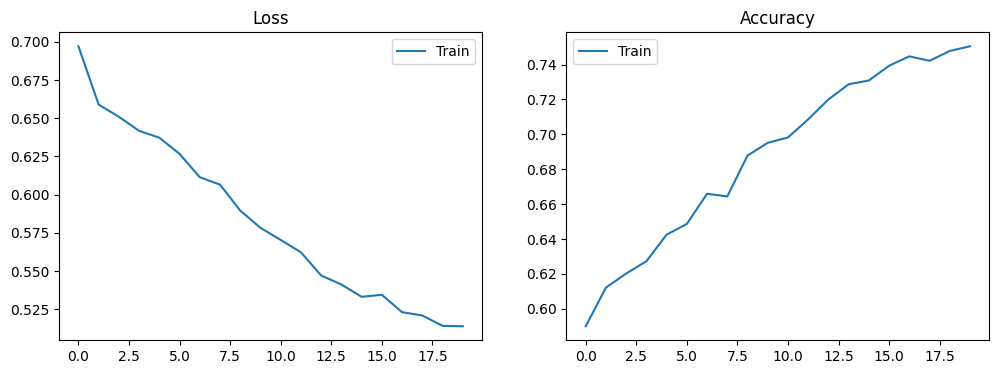

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Train')
plt.title('Accuracy'); plt.legend()
plt.show()

In [15]:
# Cell 10 - image-level evaluation
test_res = model.evaluate(test_ds, verbose=1)
print("Test (loss, acc, auc):", test_res)

# detailed report
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_probs = model.predict(test_ds)
y_pred = (y_probs.ravel() > 0.5).astype(int)

print(classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
try:
    print("ROC AUC:", roc_auc_score(y_true, y_probs))
except Exception as e:
    print("AUC error:", e)


     38/Unknown 11s 299ms/step - acc: 0.7484 - auc: 0.8359 - loss: 0.5193❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study2_negative._image1.png Reason: cv2.imread returned None
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - acc: 0.7452 - auc: 0.8315 - loss: 0.5226
Test (loss, acc, auc): [0.5278760194778442, 0.7336065769195557, 0.8213911056518555]


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study2_negative._image1.png Reason: cv2.imread returned None
     38/Unknown 11s 288ms/step❌ Error reading: /content/drive/MyDrive/Train/negative/patient07840study2_negative._image1.png Reason: cv2.imread returned None
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 285ms/step
              precision    recall  f1-score   support

         0.0     0.7856    0.7556    0.7703      1154
         1.0     0.6651    0.7018    0.6829       798

    accuracy                         0.7336      1952
   macro avg     0.7253    0.7287    0.7266      1952
weighted avg     0.7363    0.7336    0.7346      1952

Confusion matrix:
 [[872 282]
 [238 560]]
ROC AUC: 0.8214524613092522


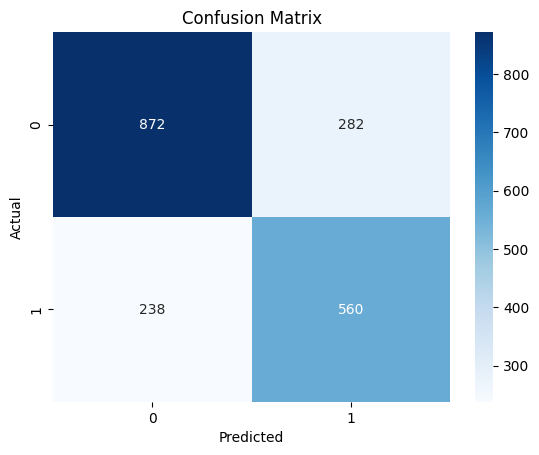

In [17]:
import seaborn as sns
cm=confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()